In [1]:
'''
Title: Searching for Stellar Cycles using Flare Rates
Authors: Matthew Scoggins, James Davenport

Code name: flare_cycles.py

Language: Python 3.6

Description of input data: Users should have a .txt file containing all of the KICs they'd like to evaluate, one KIC per line. This is the targets.txt file in main
                           Additionally, users should have the KIC .flare files for each of the KIC's they'd like to evaluate. These .flare files were generated using
                           Dr. Davenport's 'appaloosa' available at https://github.com/jradavenport/appaloosa. These files contain a whole host of information, but we only
                           used the 'Equiv_Dur' column, which is the equivalent duration for each flare. The KICs I've used are available avaible in the KICs directory at
                           https://github.com/mscoggs/flare_cycles

Description of output data: This program outputs graphs and the fit_data associated with the fits on each of those graphs. See https://github.com/mscoggs/flare_cycles for examples

From the command line: python flare_cycles.py
'''

import sys
import os
import shutil
from glob import glob
from decimal import Decimal
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14,10
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

#defining all of our constants
BJD_2008 = 2454466.500000
EPOINT = 0
BIC_THRESHOLD = 2
BASE= 2.5
MAX_DEGREE = 4
DAY_RANGE = [0,400,800,1200,1600]
GROUPING_SIZE = [1,2,3]
FIXED_ENEGRY_LIST = [1,2,3]
CMAP = plt.cm.coolwarm
COLOR = plt.cm.ScalarMappable(cmap=CMAP)
COLOR.set_array(DAY_RANGE)
NAMES=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1", "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model", "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")
EVF_DIR = 'energy_vs_frequency_plot'
EVF_SUB_DIR = 'energy_vs_frequency_subtraction_plot'
EVF_SUB_MEAN_DIR = 'energy_vs_frequency_subtraction_mean_plot'
TVF_DIR = 'time_vs_frequency_plot'
FIT_DATA_DIR = 'fit_data'
PROMISING_DIR = 'promising_bin'
NEUTRAL_DIR = 'neutral_bin'
NOISE_DIR = 'noise_bin'
BIN_LIST = [PROMISING_DIR]#, NEUTRAL_DIR, NOISE_DIR]

#searching for, and making the directories if they don't exist
for bin_ in BIN_LIST:
    if not os.path.exists(bin_):
        os.makedirs(bin_)
    if not os.path.exists(bin_+'/'+EVF_DIR):
        os.makedirs(bin_+'/'+EVF_DIR)
    if not os.path.exists(bin_+'/'+EVF_SUB_DIR):
        os.makedirs(bin_+'/'+EVF_SUB_DIR)
    if not os.path.exists(bin_+'/'+EVF_SUB_MEAN_DIR):
        os.makedirs(bin_+'/'+EVF_SUB_MEAN_DIR)
    if not os.path.exists(bin_+'/'+TVF_DIR):
        os.makedirs(bin_+'/'+TVF_DIR)
    if not os.path.exists(bin_+'/'+FIT_DATA_DIR):
        os.makedirs(bin_+'/'+FIT_DATA_DIR)

#Control plots get shown with SHOWX, which error bars end up on their plots with ERRORx and saving with SAVEX
PLOT = True
SHOWE = True
SHOWES = True
SHOWM = True
SHOWT = True
ERRORE = False
ERRORES = False
ERRORM = True
ERRORT = True
SAVEPLOT = True
SAVETXT = True

# A collection of functions

In [2]:
def get_size(file):
    '''
    Returning the number of KICs in a targettext file.

    Parameters:
    -------------------------------------------------------------------------
    file (string): The path to the file containing the list of KICs.


    Returns:
    -------------------------------------------------------------------------
    get_size_col.size (integer): The number of KICs in the file.
    '''

    temp = pd.read_table(file, names=['kic'])
    get_size_col = temp['kic'].values
    return get_size_col.size



def calc_chi_sq(data, fit, err_array):
    '''
    Caclulate the Chi-Squared value between a fit and the data.

    Parameters:
    -------------------------------------------------------------------------
    data (array, floats): the x-axis
    fit (array, floats): An array of the fit data for all of the data points, yaxis
    err_array (array, floats): An array of the error in each fit


    Returns:
    -------------------------------------------------------------------------
    chi_sq (float): the calculated Chi-Square Value
    '''

    chi_sq = np.sum(((data - fit) / err_array)**2.0)/np.size(data)
    chi_sq = np.sum(((data - fit))**2.0)/np.size(data)
    return chi_sq




def calc_error(data, multiple):
    '''
    Calculate the asymmetric Poisson error, using Eqn 7 and Eqn 12 in Gehrels 1986 ApJ, 3030, 336.

    Parameters:
    -------------------------------------------------------------------------
    data (array, floats): the x-axis
    multiple (into): The total duration (in days) of each quarter, so that we can get turn the data
                        from a #/day unit to a total #, allowing for error bar calculation

    Returns:
    -------------------------------------------------------------------------
    err_up (array, floats): the upper error bar
    err_dn (array, floats): the down error bar
    '''

    data = data*multiple
    err_dn = (np.abs(data * (1.-1./(9. * data)-1./(3.*np.sqrt(data)))**3.-data))/multiple
    err_up = (np.sqrt(data + 0.75) + 1.0)/multiple
    return err_up, err_dn





def calc_bic(size, degree, chi_sq):
    '''
    Using the Bayesian Information Criterion calculation, preventing overfitting of the data.

    Parameters:
    -------------------------------------------------------------------------
    size (int): number of data points
    degree (int): degree of the polynomial fit.
    chi_sq (float): chi-squared value.

    Returns:
    -------------------------------------------------------------------------
    bic (float): the Bayesian Information Criterion Value
    '''

    bic = size*np.log(chi_sq) + ((degree+1) * np.log(size))
    return bic




def fit_degree_k(xaxis, yaxis, err_array, degree, size, fit_linspace):
    '''
    Fitting a polynomial of degree K.

    Parameters:
    -------------------------------------------------------------------------
    xaxis, yaxis (array, floats): x and y axis values that will be fit
    err_array (array, floats):  data's associated error bars
    degree (int): degree of the polynomial to be fit
    size (int): number of data points
    fit_linspace (array, floats): a dense x-axis linspace so the fit line is continuous

    Returns:
    -------------------------------------------------------------------------
    bic (float): Bayesian Information Criterion value
    fit (array, floats): the best fit of degree k
    parameters (array, floats): coefficients for the fit
    covariance (2d-array, floats): covariance matrix associated w/ the fit.
    chi_sq (float): chi-squared value
    '''

    if(degree == 0):
        parameters = [np.mean(yaxis)]
        covariance = np.array([[np.std(yaxis)**2,0],[0,0]])
    else:
        parameters, covariance = np.polyfit(xaxis, yaxis, degree, cov=True, full =False, w=(1/err_array))

    fit = np.polyval(parameters, fit_linspace)
    fit_at_data = np.polyval(parameters, xaxis)
    chi_sq = calc_chi_sq(yaxis, fit_at_data, err_array)
    bic = calc_bic(size, degree, chi_sq)
    return bic, fit, parameters, covariance, chi_sq





def append_array(fit_data, target_index, KIC, size, group_size, degree, best_parameters, best_chi_sq, best_cov, bics):
    '''
    Updating an array that contain all of the fit data.

    Parameters:
    -------------------------------------------------------------------------
    fit_data (2d-array, floats/ints): array being updated with the fit data, which will eventually be exported (written) to a file
    target_index (int): index that keeps track of which KIC we're on
    KIC (string): KIC who's data is getting sent to the array
    size (int): number of data points
    degree (int): degree of the fit
    best_parameters (array, floats): coefficients of the best fit polynomial
    best_chi_sq (float): chi-square of the best fit
    best_cov (2d-array): covariance matrix of the best-fit, returned by polyfit
    bics (4 floats): the bics from each degree of fit, 0 if there wasn't a fit

    Returns:
    -------------------------------------------------------------------------
    fit_data (2d-array, floats/ints): array being updated with the fit data, which will eventually be exported (written) to a file
    '''

    fit_data[target_index, 0] = KIC
    fit_data[target_index, 1] = size
    fit_data[target_index, 2] = group_size
    fit_data[target_index, 3] = degree
    fit_data[target_index, 4] = '{}'.format('%.5f'%best_chi_sq)
    length = len(best_parameters)

    for x in range(length):

        #working backwards because best_parameters varies in length
        fit_data[target_index, (9-length+x)] = '{}'.format('%.15f'%best_parameters[x])
        fit_data[target_index, (13-length+x)] = '{}'.format('%.15f'%(np.sqrt(best_cov[x,x])))

    for x in range(MAX_DEGREE):

        fit_data[target_index, (13+x)] = '{}'.format('%.15f'%(bics[-(x+1)]))

    return fit_data





def compare_fits(xaxis, yaxis, err_array, fit_linspace):
    '''
    Comparing two fits, and determining which fit is the 'best' based on the Bayseian information criterion

    Parameters:
    -------------------------------------------------------------------------
    xaxis, yaxis (array, floats): x and y axis values that will be fit
    err_array (array, floats):  data's associated error bars
    fit_linspace (array, floats): a dense x-axis linspace so the fit line is continuous

    Returns:
    -------------------------------------------------------------------------
    best_fit (array, floats): data from the best fit polynomial
    best_parameters (array, floats): coefficients of polynomial being used to fit the data
    best_covariance (2d-array, floats): covariance matrix of the best_fit, returned by polyfit
    best_chi_sq (array, floats): Chi-Square of the best fit
    degree_of_best_fit (int): degree of the polynomial being used to fit the data
    size (int): number of data points in the fit
    bics (array, floats): The bics from each fit. 0 if no fit was found
    '''

    bics = np.zeros(MAX_DEGREE)
    size = np.size(xaxis)
    degree_of_best_fit = 0
    bic_min, best_fit, best_parameters, best_covariance, best_chi_sq = fit_degree_k(xaxis, yaxis, err_array, degree_of_best_fit, size, fit_linspace)
    bics[0] = bic_min
    degree = 1

    #fitting different degree polynomials, starting at 0
    while(degree<MAX_DEGREE):

        # polyval needs the number of data points must exceed order + 2, order = degree+1
        if(size <= degree+3): break

        bic_new, fit, parameters, covariance, chi_sq = fit_degree_k(xaxis, yaxis, err_array, degree, size, fit_linspace)
        bics[degree] = bic_new

        if ((bic_min - bic_new) >=BIC_THRESHOLD):

            bic_min, best_fit, best_parameters, best_covariance, best_chi_sq = bic_new, fit, parameters, covariance, chi_sq
            degree_of_best_fit = degree

        degree+=1

    return best_fit, best_parameters, best_covariance, best_chi_sq, degree_of_best_fit, size, bics






def init_data_array(num_rows):
    '''
    initializing the array that will hold the fit data, which gets exported to a .txt file

    Parameters:
    -------------------------------------------------------------------------
    num_rows (int): number of rows that we need in the fit_data.txt

    Returns:
    -------------------------------------------------------------------------
    fit_data (2d-array, floats/ints): array being updated with the fit data, which will eventually be exported (written) to a file
    target_index (int): keeps track of which row we're on
    '''

    fit_data = np.zeros((num_rows, 17), dtype='O')
    fit_data[0] = ["#This is a file containing the data involved in the best fit of our KICs",'','','','','','','','','','','','','','','','']
    fit_data[1] = ["#KIC", 'N', 'group size', 'best degree', 'chi_sq', 'X^3', 'X^2', 'X^1', 'X^0', 'Error3', 'Error2', 'Error1', 'Error0', 'BIC3', 'BIC2','BIC1','BIC0']
    target_index = 2
    return fit_data, target_index



def get_label(best_parameters, degree_of_best_fit, group_size):
    '''
    Creates the label that will show up on graphs

    Parameters:
    -------------------------------------------------------------------------
    best_parameters (array, floats): coefficients of polynomial being used to fit the data
    degree_of_best_fit (int): degree of the polynomial being used to fit the data
    group_size (int): number of points that go into each grouping

    Returns:
    -------------------------------------------------------------------------
    label (string): a graph-ready label
    '''

    label = "BIC-fit\nP_0: "+ str('%.2E' % Decimal(best_parameters[-1]))

    #adding the parameters to the label
    for x in range(degree_of_best_fit): label = label + "\nP_"+str(x+1)+": "+str('%.2E' % Decimal(best_parameters[-(x+2)]))
    label = label + "\ngroup size: " + str(group_size)
    return label




def calc_error_during_subtraction(data, data_err, fit_coeff, coeff_err, total_duration):
    '''
    Propogates the error during the subtraction step.

    Parameters:
    -------------------------------------------------------------------------
    data (array, floats): yaxis, frequency
    data_err (array, floats): error in the yaxis, poisson error
    fit_coeff (array, floats): coefficients involve in the fit done by curve_fit
    coeff_err (array, floats): error in the coefficients
    total_duration (int): total number of days that the star was observed

    Returns:
    -------------------------------------------------------------------------
    difference_err (array, floats): the propogated errors
    '''

    a,b,c = fit_coeff[0],fit_coeff[1],fit_coeff[2]
    da,db,dc = coeff_err[0],coeff_err[1],coeff_err[2]

    #using df = sqrt(df/dx * dx^2  +  df/dy * dy^2 + ...) where f is our powerlaw
    df_squared = (a* data * BASE**(-b*data)*db)**2 + (BASE**(-b*data)*da)**2 + dc**2

    #if f = A + B, df = sqrt(da^2 + db^2)
    difference_err = np.sqrt(df_squared + data_err**2)
    return difference_err




def power_law(x, a, b, c):
    '''A powerlaw function, parameters determined by curve_fit'''

    return a*BASE**(-b*x)+c




def plot_tvf(KIC, files, num_files, tvf_data, fixed_energy, target_index, bin_, **kwargs):
    '''
    plotting the time vs frequency for each KIC, at a fixed energy. Choose a fixed energy, and get the frequency
    for each quarter at the energy

    Parameters:
    -------------------------------------------------------------------------
    KIC (string): name of the star being studied
    files: All of the quarters, .flare files
    num_files (int): total number of quarters
    tvf_data (2d-array, floats/int): the array that will become the file holding all of the fit data for tvf fit
    fixed_energy (float): energy the we're fixing on the xaxis of evf
    target_index (int): an index that keeps track of which row we're on in tvf_data
    bin_ (string): the bin we're working on, one of: promising, neutral, noise (good, bad, ugly)
    '''

    if(PLOT):

        plt.figure()
        plt.title(str(KIC))
        plt.ylabel(r"$\nu$")
        plt.xlabel("$BJD_{TDB}-2454832$")
        plt.yscale('log')

    time = np.array([])
    frequency = np.array([])
    err_array_up = np.array([])
    err_array_dn = np.array([])

    #loop over each .flare file, which represents one quarter
    for x in range(num_files):

        #total number of days in each quarter
        total_duration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0]
        df = pd.read_table(files[x], comment="#", delimiter=",", names=NAMES)

        #grabbing the energy (equivalent duration) column from each file, sorting, then including only the positive values so it can be logged
        energy = np.array(df['Equiv_Dur'])
        positive = np.where(energy > 0)
        energy_p = energy[positive]
        sort = np.argsort(energy_p)
        evf_x_energy = (np.log10(energy_p) + EPOINT)[sort][::-1]
        evf_x_energy = evf_x_energy[np.isfinite(evf_x_energy)]
        evf_y_frequency = (np.arange(1, len(evf_x_energy)+1, 1))/total_duration

        #rarey, the restrictions remove all equiv_dur points
        if(len(evf_x_energy) == 0): continue

        #checking that the energy constant isn't out of bound,otherwise, interpolate doesn't work
        if(np.amax(evf_x_energy) >= fixed_energy >= np.amin(evf_x_energy)):

            #finding the mean time for a file
            mean_start = np.sum(df['t_start'])/len(df['t_start'])

            #interpolating the ffd_y
            ffdYAtEnergy = np.interp(fixed_energy, evf_x_energy[::-1], evf_y_frequency[::-1])
            time = np.append(time, mean_start)
            frequency = np.append(frequency, ffdYAtEnergy)
            err_up, err_dn = calc_error(ffdYAtEnergy, total_duration)
            err_array_up = np.append(err_array_up, err_up)
            err_array_dn = np.append(err_array_dn, err_dn)

    #sometimes the fixed energy values has no intersection with the lines, if so, move on to the next KIC
    if(len(time) == 0): return

    #creating a dense linespace so the fit is smooth
    fit_linspace = np.linspace(min(time), max(time), num=100)
    best_fit, best_parameters, best_covariance, best_chi_sq, degree_of_best_fit, size, bics = compare_fits(time, frequency, err_array_up, fit_linspace)
    tvf_data = append_array(tvf_data, target_index, KIC, size, 1, degree_of_best_fit, best_parameters, best_chi_sq, best_covariance, bics)

    label = get_label(best_parameters, degree_of_best_fit, 1)
    if(PLOT):
        plt.scatter(time, frequency, c=time, cmap=CMAP, lw=6)
        plt.plot(fit_linspace, best_fit, 'black', lw=4, label=label)
        if(kwargs['errort']==True): plt.errorbar(time, frequency, yerr = [err_array_dn,err_array_up], c='black', fmt='o', markersize=0, elinewidth=.8, capsize=6)#plotting error
        plt.legend(loc="upper right")

        if(kwargs['save']==True): plt.savefig(bin_+'/'+TVF_DIR+'/'+str(KIC)+'_energy_equals'+str(fixed_energy)+'.png')
        if(kwargs['showt']==True): plt.show()
        plt.close()




def plot_evf(KIC, files, num_files,bin_, **kwargs):
    '''
    Plotting a reverse cummulative sum of the flare frequency for each quarter.

    Parameters:
    -------------------------------------------------------------------------
    KIC (string): name of the star being studied
    files: All of the quarters, .flare files
    num_files (int): total number of quarters
    bin_ (string): the bin we're working on, one of: promising, neutral, noise (good, bad, ugly)

    Returns:
    -------------------------------------------------------------------------
    quarterly_evf_x_energy (2d-array, floats): each element is an array holding the x axis, energy, for a quarter
    quarterly_evf_y_frequency (2d-array, floats): each element is an array holding the y axis, frequency, for a quarter
    popt (array, floats): the curve_fit parameters
    perr (array, floats): the error in the curve_fit parameters
    total_duration (float): the total number of days for a KIC
    time (array, floats): the mean times for each quarter
    offset (float): a value that shifts the xaxis so that the first point starts at zero, helping the fit
    success (bool): curve_fit rarely fails to find a fit. If it fails, we can't do the subtraction and mean analysis
    '''

    if(PLOT):

        plt.figure()
        plt.title(str(KIC))
        plt.ylabel(r"$\nu$")
        plt.xlabel("Log Equivalent Duration")
        plt.yscale('log')

    err_array = np.array([])
    total_evf_x_energy = np.array([])
    total_evf_y_frequency = np.array([])
    quarterly_evf_x_energy = []
    quarterly_evf_y_frequency = []
    time = np.array([])

    #loop over each .flare file, which represents one quarter
    for x in range(num_files):

        #total number of days in each quarter
        total_duration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0]
        df = pd.read_table(files[x], comment="#", delimiter=",", names=NAMES)

        #grabbing the energy (equivalent duration) column from each file, sorting, then including only the positive values so it can be logged
        energy = np.array(df['Equiv_Dur'])
        positive = np.where(energy > 0)
        energy_p = energy[positive]
        sort = np.argsort(energy_p)
        evf_x_energy = np.log10((energy_p + EPOINT)[sort][::-1])
        evf_y_frequency = (np.arange(1, len(evf_x_energy)+1, 1))/total_duration

        #removing data below the ED68i cutoff, only interested in the stronger flares
        ok68 = (evf_x_energy >= np.log10(np.median(df['ED68i'])) + EPOINT)

        #collecting data for the evf subtraction step
        if (any(ok68)):
            quarterly_evf_x_energy.append(evf_x_energy[ok68])
            quarterly_evf_y_frequency.append(evf_y_frequency[ok68])

            #finding the mean time for each file
            time = np.append(time, np.sum(df['t_start'])/len(df['t_start']))

        total_evf_x_energy = np.append(total_evf_x_energy, evf_x_energy[ok68])
        total_evf_y_frequency = np.append(total_evf_y_frequency, evf_y_frequency[ok68])
        err_up, err_dn = calc_error(evf_y_frequency[ok68], total_duration)

        #err_up > err_dn, which is why we're using that for the error bars
        err_array = np.append(err_array, err_up)

        if(PLOT):

            plt.plot(evf_x_energy[ok68], evf_y_frequency[ok68], lw = 1, c = CMAP(x/float(len(files))))
            if(kwargs['errore']==True): plt.errorbar(evf_x_energy[ok68], evf_y_frequency[ok68], yerr = [err_dn, err_up], c = 'black', elinewidth=.3, fmt='o', markersize = .55)

    sort = np.argsort(total_evf_x_energy)
    if(len(total_evf_x_energy) == 0):  return 0, 0, 0, 0, 0, 0, 0, False

    try:

         #offset the data at x=0 to reduce error in the the fit
        offset = min(total_evf_x_energy)
        popt, pcov = curve_fit(power_law, total_evf_x_energy[sort]-offset, total_evf_y_frequency[sort], p0=(.02, .4, .02),maxfev = 3000, sigma = err_array)
        perr = np.sqrt(np.diag(pcov))

        if(PLOT):
            power_fit = power_law(total_evf_x_energy[sort]-offset, *popt)

            #restricting the fit to points in the data's y-axis range
            positive = np.where(power_fit > min(total_evf_y_frequency))
            plt.plot(total_evf_x_energy[sort][positive], power_fit[positive], c='black', lw=4, label="Best-Fit")
            plt.legend(loc='upper right')
            cbar = plt.colorbar(COLOR, ticks=DAY_RANGE)
            cbar.set_label('$BJD_{TDB}-2454832$', rotation=270)
            if(kwargs['save']==True): plt.savefig(bin_+'/'+EVF_DIR+'/'+ str(KIC) + '.png')
            if(kwargs['showe']==True): plt.show()
            plt.close()

        success = True

    except Exception as e:
        print("ERROR: Couldn't fit a power_law to " + KIC + ". Moving on to the next KIC")
        print("EXCEPTION: ",e)
        success = False
        popt = perr = offset = 0

    return quarterly_evf_x_energy, quarterly_evf_y_frequency, popt, perr, total_duration, time,offset, success




def plot_evf_sub(KIC, quarterly_evf_x_energy, quarterly_evf_y_frequency, popt,perr,offset, total_duration,bin_, **kwargs):
    '''
    Takes the fit from plot_evf, and each of the quarters, and finds the difference between them.

    Parameters:
    -------------------------------------------------------------------------
    KIC (string): name of the star being studied
    quarterly_evf_x_energy (2d-array, floats): each element is an array holding the x axis, energy, for a quarter
    quarterly_evf_y_frequency (2d-array, floats): each element is an array holding the y axis, frequency, for a quarter
    popt (array, floats): the curve_fit parameters
    perr (array, floats): the error in the curve_fit parameters
    offset (float): a value that shifts the xaxis so that the first point starts at zero, helping the fit
    total_duration (float): the total number of days for a KIC
    bin_ (string): the bin we're working on, one of: promising, neutral, noise (good, bad, ugly)

    Returns:
    -------------------------------------------------------------------------
    mean_frequency (array, floats): the mean frequency for each quarter's difference
    mean_frequency_err (array, floats): the error for the mean frequency for each quarter's difference
    '''

    if(PLOT):

        plt.figure()
        plt.title(str(KIC))
        plt.ylabel(r'$\nu$ - $\bar \nu$')
        plt.xlabel("Log Equivalent Duration")

    mean_frequency = np.array([])
    mean_frequency_err = np.array([])

    for q in range(len(quarterly_evf_x_energy)):

        fit = power_law(quarterly_evf_x_energy[q]-offset, *popt)
        err_up, err_dn = calc_error(quarterly_evf_y_frequency[q], total_duration)

        #propogating the error
        difference_err = calc_error_during_subtraction(quarterly_evf_x_energy[q]-offset, err_up, popt, perr ,total_duration)
        difference = quarterly_evf_y_frequency[q]-fit

        if(PLOT): plt.plot(quarterly_evf_x_energy[q], difference, c = CMAP(q/float(len(quarterly_evf_x_energy))))
        if(kwargs['errores']==True): plt.errorbar(quarterly_evf_x_energy[q], difference, yerr = [difference_err, difference_err], c = 'black', elinewidth=.6, fmt='o', markersize = 2, capsize=2)

        #meaning the difference from each quarter, which will be used in plot_evf_sub_mean
        mean = np.mean(difference)
        mean_err = np.sqrt(np.sum(err_up**2))/np.size(err_up)
        mean_frequency = np.append(mean_frequency, mean)
        mean_frequency_err = np.append(mean_frequency_err, mean_err)

    if(PLOT):
        cbar = plt.colorbar(COLOR, ticks=DAY_RANGE)
        cbar.set_label('$BJD_{TDB}-2454832$', rotation=270)
        if(kwargs['save']==True): plt.savefig(bin_+'/'+EVF_SUB_DIR+'/'+ str(KIC) + '.png')
        if(kwargs['showes']==True): plt.show()
        plt.close()

    return mean_frequency, mean_frequency_err




def plot_evf_sub_mean(KIC, time, mean_frequency, mean_frequency_err,  group_size, evf_sub_mean_data, target_index,bin_,**kwargs):
    '''
    plots the mean difference for each quarter (calculated in plot_evf_sub) over time

    Parameters:
    -------------------------------------------------------------------------
    KIC (string): name of the star being studied
    time (array, floats): the mean times for each quarter
    mean_frequency (array, floats): the mean frequency for each quarter's difference
    mean_frequency_err (array, floats): the error for the mean frequency for each quarter's difference
    group_size (int): number of points that go into each grouping
    evf_sub_mean_data (2d-array, floats/int): the array that will become the file holding all of the fit data for efv_sub_mean fit
    target_index (int): an index that keeps track of which row we're on in tvf_data
    bin_ (string): the bin we're working on, one of: promising, neutral, noise (good, bad, ugly)
    '''

    #binning the data into groups of group_size
    if(group_size == 1): grouped_time, grouped_mean_vals, grouped_mean_errs = time, mean_frequency, mean_frequency_err

    else:

        grouped_time = np.zeros([math.ceil(len(time)/group_size)])
        grouped_mean_vals = np.zeros([math.ceil(len(time)/group_size)])
        grouped_mean_errs = np.zeros([math.ceil(len(time)/group_size)])
        index = iterations = 0

        for x in range(len(time)):

            grouped_time[index] += time[x]
            grouped_mean_vals[index] += mean_frequency[x]
            grouped_mean_errs[index] += mean_frequency_err[x]**2
            iterations += 1

            if((iterations == group_size) or (x == (len(time)-1))):

                grouped_time[index] = grouped_time[index]/iterations
                grouped_mean_vals[index] = grouped_mean_vals[index]/iterations
                grouped_mean_errs[index] = np.sqrt(grouped_mean_errs[index])
                iterations = 0
                index += 1

    #creating a dense linespace so the fit is smooth
    fit_linspace = np.linspace(min(grouped_time), max(grouped_time), num=100)
    best_fit, best_parameters, best_covariance, best_chi_sq, degree_of_best_fit, size, bics = compare_fits(grouped_time, grouped_mean_vals, grouped_mean_errs, fit_linspace)
    evf_sub_mean_data = append_array(evf_sub_mean_data, target_index, KIC, size, group_size, degree_of_best_fit, best_parameters, best_chi_sq, best_covariance, bics)

    if(PLOT):
        plt.figure()
        plt.title(str(KIC))
        plt.ylabel(r'$\overline{\nu - \bar \nu}$')
        plt.xlabel("$BJD_{TDB}-2454832$")

        label = get_label(best_parameters, degree_of_best_fit, group_size)
        plt.scatter(grouped_time, grouped_mean_vals, c=grouped_time, cmap=CMAP, lw=6)
        plt.plot(fit_linspace, best_fit, 'black', lw=4, label=label)
        if(kwargs['errorm']==True): plt.errorbar(grouped_time, grouped_mean_vals, yerr = grouped_mean_errs, c='black', fmt='o', markersize=0, elinewidth=.8, capsize=6)
        plt.legend(loc='upper right')

        if(kwargs['save']==True): plt.savefig(bin_+'/'+EVF_SUB_MEAN_DIR+'/'+ str(KIC) + '_group_size_' + str(group_size) + '.png')
        if(kwargs['showm']==True): plt.show()
        plt.close()

# 'Main'

Working on 'promising_bin' which has a total of 1 targets.
Working on the energy_vs_frequency analysis for KIC: 005791720


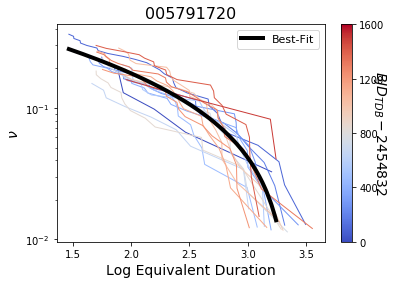

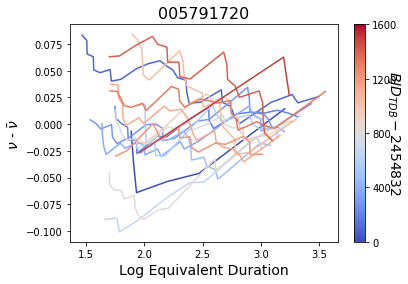

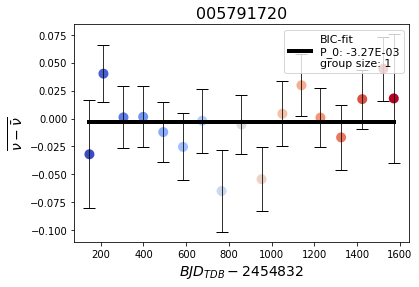

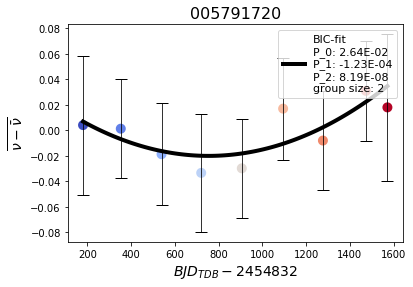

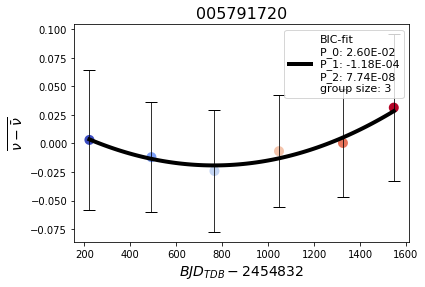

Working on the time_vs_frequency analysis for KIC: 005791720 at energy: 1


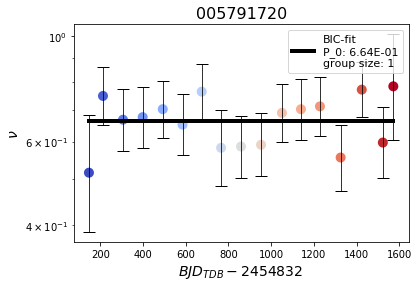

Working on the time_vs_frequency analysis for KIC: 005791720 at energy: 2


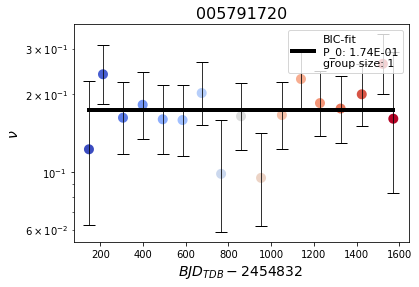

Working on the time_vs_frequency analysis for KIC: 005791720 at energy: 3


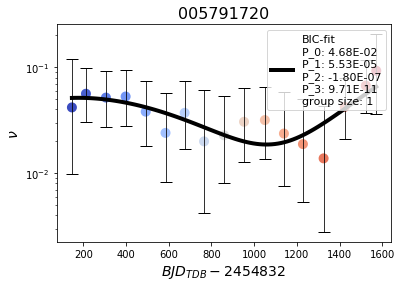

In [3]:
#cycling through three bins: promising, neutral and noise (good, bad, ugly). Code to determine which KIC belong to which bin available on the notebook
for bin_ in BIN_LIST:

    file = bin_+'/'+'target_single.txt'
    target_count = get_size(file)
    print("Working on \'"+bin_+"\' which has a total of "+str(target_count)+" targets.")

    ##################################################################################################
    #the energy vs frequency analysis
    ##################################################################################################
    targets = open(file, "r")

    #initializing the array that will contain the fit data. target_index keeps track of which KIC we're on, allowing us to add the fit data to the right row
    evf_sub_mean_data, target_index = init_data_array(target_count*len(GROUPING_SIZE) + 2)

    for line in targets:

        #each line of the targets.txt file containt a KIC
        KIC = line.rstrip('\n')
        print("Working on the energy_vs_frequency analysis for KIC: "+str(KIC))
        files = sorted(glob('KICs/'+KIC+"/*.flare"))
        num_files = len(files)
        quarterly_evf_x_energy, quarterly_evf_y_frequency, popt, perr, total_duration, time, offset, success  = plot_evf(KIC, files, num_files,bin_, showe=SHOWE,errore=ERRORE,save=SAVEPLOT)

        #rarely, plot_evf will throw and exception because curve_fit fails to find a fit, so success== everything went well
        if(success):

            #subtracting the fit from each quarter and plotting it
            mean_frequency, mean_frequency_err = plot_evf_sub(KIC, quarterly_evf_x_energy, quarterly_evf_y_frequency, popt,perr, offset, total_duration,bin_,showes=SHOWES,errores=ERRORES, save=SAVEPLOT)

            for group_size in GROUPING_SIZE:

                #taking the mean of the subtraction found for each quarter in the last function, and plotting that mean over time
                plot_evf_sub_mean(KIC, time, mean_frequency, mean_frequency_err, group_size, evf_sub_mean_data, target_index,bin_,errorm=ERRORM,showm=SHOWM,save=SAVEPLOT)
                target_index+= 1

    targets.close()
    if(SAVETXT==True): np.savetxt(bin_+'/'+FIT_DATA_DIR+'/evf_mean_sub.txt', evf_sub_mean_data, fmt = '% 20s', delimiter=' ', newline='\n', header='', footer='', comments='# ')


    ##################################################################################################
    #the time vs energy analysis
    ##################################################################################################
    for energyConstant in FIXED_ENEGRY_LIST:

        targets = open(file, "r")
        fixed_energy = energyConstant + EPOINT
        tvf_data, target_index = init_data_array(target_count + 2)

        for line in targets:

            #each line of the targets.txt file containt a KIC
            KIC = line.rstrip('\n')
            print("Working on the time_vs_frequency analysis for KIC: "+str(KIC)+ " at energy: "+str(fixed_energy))
            files = glob('KICs/'+KIC+"/*.flare")
            num_files = len(files)
            plot_tvf(KIC, files, num_files, tvf_data, fixed_energy, target_index, bin_, showt=SHOWT, errort = ERRORT,save=SAVEPLOT)
            target_index += 1

        targets.close()
        if(SAVETXT==True): np.savetxt(bin_+'/'+FIT_DATA_DIR+'/fixed_energy_equals_'+str(fixed_energy)+'.txt', tvf_data, fmt = '% 20s', delimiter=' ', newline='\n', header='', footer='', comments='# ')

In [144]:
#Seperating the bins
'''f=open('fit_data/fixed_energy_equals_1.txt',"r")
KICS=[]
count = 0
for line in f:
    count += 1
    KICS.append(line.split()[0])
f.close()

del KICS[0]
del KICS[0]
KICS = np.array(KICS)
count = count - 2
degree_sum = np.zeros(count)
print(count)

for filename in os.listdir('fit_data'):
    f=open('fit_data/'+filename,"r")
    if(filename == 'evf_mean_sub.txt'):
        index = 0
        x = 0
        for line in f:
            x+=1
            if(x==1 or x==2): continue
            #print((line.split()[3]))
            degree_sum[index] += int(line.split()[3])
            if((x-2) % 3 == 0):
                index+=1
    else:
        x=0
        for line in f:
            x+=1
            if(x==1 or x==2): continue
            degree_sum[x-3] += int(line.split()[3])
    f.close()
promising_KICS = KICS[np.where(degree_sum >= 3)]
neutral_KICS = KICS[np.where((3 > degree_sum) & (degree_sum > 0))]
noise_KICS = KICS[np.where(degree_sum == 0)]

np.savetxt(promising_dir+"/targets.txt",promising_KICS, fmt = '%s')
np.savetxt(neutral_dir+"/targets.txt",neutral_KICS, fmt = '%s')
np.savetxt(noise_dir+"/targets.txt",noise_KICS, fmt = '%s')
f= open(promising_dir+"/targets.txt","r")
count=0
for line in f: count+=1
f.close()

f= open(neutral_dir+"/targets.txt","r")
for line in f: count+=1
f.close()
f= open(noise_dir+"/targets.txt","r")
for line in f: count+=1
print(count)
print("These two numbers should be equal. If not, something went wrong")
f.close()'''

'f=open(\'fit_data/fixed_energy_equals_1.txt\',"r")\nKICS=[]\ncount = 0\nfor line in f:\n    count += 1\n    KICS.append(line.split()[0])\nf.close()\n\ndel KICS[0]\ndel KICS[0]\nKICS = np.array(KICS)\ncount = count - 2\ndegree_sum = np.zeros(count)\nprint(count)\n\nfor filename in os.listdir(\'fit_data\'):\n    f=open(\'fit_data/\'+filename,"r")\n    if(filename == \'evf_mean_sub.txt\'):\n        index = 0\n        x = 0\n        for line in f:\n            x+=1\n            if(x==1 or x==2): continue\n            #print((line.split()[3]))\n            degree_sum[index] += int(line.split()[3])\n            if((x-2) % 3 == 0):\n                index+=1\n    else:\n        x=0\n        for line in f:\n            x+=1\n            if(x==1 or x==2): continue\n            degree_sum[x-3] += int(line.split()[3])\n    f.close()\npromising_KICS = KICS[np.where(degree_sum >= 3)]\nneutral_KICS = KICS[np.where((3 > degree_sum) & (degree_sum > 0))]\nnoise_KICS = KICS[np.where(degree_sum == 0)]\n\

In [145]:
#Moving the KICs into a structure that's easier for the program to read as-is
'''
kic_list = 'targets_full.txt'
direc = 'KICs_2'
new_direc = 'KICs_full'

for filename in os.listdir(direc):
    og_name = filename
    KIC = str(filename).strip('kplr')[0:9]
    if not os.path.exists(new_direc + '/' + KIC): #searching for, and making the directories if they don't exist
        os.makedirs(new_direc + '/' + KIC)
        with open(kic_list, 'a') as the_file:
            the_file.write(KIC+"\n")
        the_file.close()
    #os.rename(direc+"/"+og_name, new_direc+"/"+KIC+"/"+og_name)
    shutil.move(direc+"/"+og_name, new_direc+"/"+KIC+"/"+og_name)'''

'\nkic_list = \'targets_full.txt\'\ndirec = \'KICs_2\'\nnew_direc = \'KICs_full\'\n\nfor filename in os.listdir(direc):\n    og_name = filename\n    KIC = str(filename).strip(\'kplr\')[0:9]\n    if not os.path.exists(new_direc + \'/\' + KIC): #searching for, and making the directories if they don\'t exist\n        os.makedirs(new_direc + \'/\' + KIC)\n        with open(kic_list, \'a\') as the_file:\n            the_file.write(KIC+"\n")\n        the_file.close()\n    #os.rename(direc+"/"+og_name, new_direc+"/"+KIC+"/"+og_name)\n    shutil.move(direc+"/"+og_name, new_direc+"/"+KIC+"/"+og_name)'